In [4]:
import pandas as pd
import numpy as np
import random

In [5]:
LOCATION = '../input/mean-max-min-std/'

In [6]:
participants = pd.read_csv(LOCATION + 'participants.csv')
control = participants[participants['diagnosis'] == 'Control']['id'].to_list()
schizophrenic = participants[participants['diagnosis'] != 'Control']['id'].to_list()

len(control), len(schizophrenic)

(206, 130)

In [7]:
tr = int(len(control) * 0.8)
va = tr + int(len(control) * 0.1)

train_list = control[:tr]
valid_list = control[tr:va]
test_list = control[va:]

tr = int(len(schizophrenic) * 0.8)
va = tr + int(len(schizophrenic) * 0.1)

train_list = train_list + schizophrenic[:tr]
valid_list = valid_list + schizophrenic[tr:va]
test_list = test_list + schizophrenic[va:]

random.shuffle(train_list)
random.shuffle(valid_list)
random.shuffle(test_list)

len(train_list), len(valid_list), len(test_list)

(268, 33, 35)

In [8]:
train_x, train_y = np.empty((0, 61, 73, 61), np.float32), np.empty(0, int)
test_x, test_y = np.empty((0, 61, 73, 61), np.float32), np.empty(0, int)
valid_x, valid_y = np.empty((0, 61, 73, 61)), np.empty(0, int)

In [9]:
%%time

for subject in (train_list):
    diagnosis = participants[participants['id'] == subject].iloc[0].diagnosis
    path = LOCATION + 'max_images/' + diagnosis + '/sub-'+subject+'.npz'
    
    x = np.load(path)['arr_0']
    #y = 0 if diagnosis == 'Control' else 1
    y = 0 if diagnosis == 'Control' else 1

    train_x = np.append(train_x, [x], axis=0)
    train_y = np.append(train_y, [y], axis=0)
    
train_x.shape, train_y.shape

CPU times: user 19.2 s, sys: 17.6 s, total: 36.8 s
Wall time: 41.5 s


((268, 61, 73, 61), (268,))

In [10]:
%%time

for subject in (valid_list):
    diagnosis = participants[participants['id'] == subject].iloc[0].diagnosis
    path = LOCATION + 'mean_images/' + diagnosis + '/sub-'+subject+'.npz'
    
    x = np.load(path)['arr_0']
    #y = 0 if diagnosis == 'Control' else 1
    y = 0 if diagnosis == 'Control' else 1

    valid_x = np.append(valid_x, [x], axis=0)
    valid_y = np.append(valid_y, [y], axis=0)
    
valid_x.shape, valid_y.shape

CPU times: user 790 ms, sys: 276 ms, total: 1.07 s
Wall time: 1.86 s


((33, 61, 73, 61), (33,))

In [11]:
%%time

for subject in (test_list):
    diagnosis = participants[participants['id'] == subject].iloc[0].diagnosis
    path = LOCATION + 'max_images/' + diagnosis + '/sub-'+subject+'.npz'
    
    x = np.load(path)['arr_0']
    #y = 0 if diagnosis == 'Control' else 1
    y = 0 if diagnosis == 'Control' else 1

    test_x = np.append(test_x, [x], axis=0)
    test_y = np.append(test_y, [y], axis=0)
    
test_x.shape, test_y.shape

CPU times: user 730 ms, sys: 293 ms, total: 1.02 s
Wall time: 1.47 s


((35, 61, 73, 61), (35,))

In [12]:
train_x = train_x.astype('float32')
valid_x = valid_x.astype('float32')
test_x = test_x.astype('float32')

In [13]:
import tensorflow as tf
from scipy import ndimage

@tf.function
def rotate(volume):
    def scipy_rotate(volume):
        angles = [-20, -10, -5, 5, 10, 20]
        angle = random.choice(angles)
        volume = ndimage.rotate(volume, angle, reshape=False)
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [58]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.models.Sequential()

model.add(keras.Input((61, 73, 61, 1)))
model.add(layers.Conv3D(filters=64, kernel_size=3, activation="relu"))
model.add(layers.MaxPool3D(pool_size=2))
model.add(layers.BatchNormalization())
model.add(layers.Conv3D(filters=128, kernel_size=3, activation="relu"))
model.add(layers.MaxPool3D(pool_size=2))
model.add(layers.BatchNormalization())
model.add(layers.Conv3D(filters=256, kernel_size=3, activation="relu"))
model.add(layers.MaxPool3D(pool_size=2))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dropout(.5))
model.add(layers.Dense(units=1024, activation='relu'))
model.add(layers.Dropout(.5))
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dropout(.5))
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
          
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 59, 71, 59, 64)    1792      
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 29, 35, 29, 64)    0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 29, 35, 29, 64)    256       
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 27, 33, 27, 128)   221312    
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 13, 16, 13, 128)   0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 13, 16, 13, 128)   512       
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 11, 14, 11, 256)  

In [59]:
train_loader = tf.data.Dataset.from_tensor_slices((train_x, train_y))
validation_loader = tf.data.Dataset.from_tensor_slices((valid_x, valid_y))

batch_size = 2
train_dataset = (
    train_loader.shuffle(len(train_x))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_loader.shuffle(len(valid_x))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [60]:
'''initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
'''
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.01),
              metrics=["acc"])

checkpoint_cb = keras.callbacks.ModelCheckpoint("3d_image_classification.h5", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

In [61]:
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
134/134 - 16s - loss: 0.9993 - acc: 0.5597 - val_loss: 1.3168 - val_acc: 0.5455
Epoch 2/100
134/134 - 15s - loss: 0.8637 - acc: 0.5746 - val_loss: 0.6535 - val_acc: 0.6061
Epoch 3/100
134/134 - 16s - loss: 0.7687 - acc: 0.6157 - val_loss: 0.8912 - val_acc: 0.3939
Epoch 4/100
134/134 - 15s - loss: 0.7555 - acc: 0.5784 - val_loss: 0.7503 - val_acc: 0.5758
Epoch 5/100
134/134 - 15s - loss: 0.5834 - acc: 0.6828 - val_loss: 0.5770 - val_acc: 0.6364
Epoch 6/100
134/134 - 15s - loss: 0.6403 - acc: 0.6679 - val_loss: 0.7268 - val_acc: 0.6061
Epoch 7/100
134/134 - 15s - loss: 0.6871 - acc: 0.6381 - val_loss: 0.6299 - val_acc: 0.6364
Epoch 8/100
134/134 - 15s - loss: 0.5808 - acc: 0.6716 - val_loss: 0.5737 - val_acc: 0.6667
Epoch 9/100
134/134 - 15s - loss: 0.5660 - acc: 0.7127 - val_loss: 0.6493 - val_acc: 0.6061
Epoch 10/100
134/134 - 14s - loss: 0.5833 - acc: 0.6679 - val_loss: 0.6370 - val_acc: 0.6970
Epoch 11/100
134/134 - 15s - loss: 0.5974 - acc: 0.7052 - val_loss: 1.0886 - va

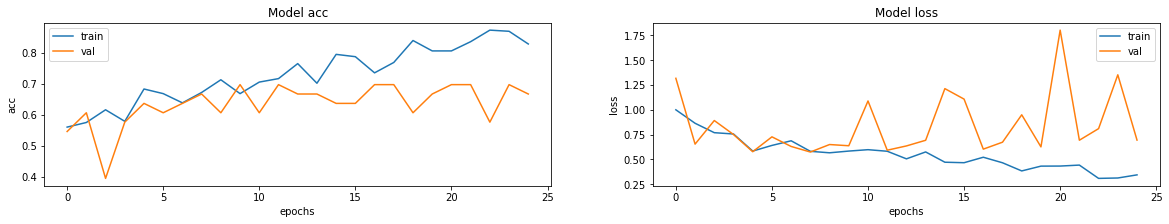

In [62]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [63]:
model.load_weights("3d_image_classification.h5")

In [81]:
def get_probs(data):
    y = np.empty(0)
    
    for i in range(data.shape[0]):
        pred = model.predict(np.expand_dims(np.expand_dims(data[i], axis=0), axis=4))
        y = np.append(y, pred[0], axis=0)
        
    return y

def get_predictions(data, threshold):
    y = get_probs(data)
    return np.where(y > threshold, 1, 0).astype(int)

In [102]:
pred_y = get_predictions(train_x, 0.5)

In [103]:
from sklearn import metrics
print("Accuracy:", metrics.accuracy_score(train_y, pred_y))

Accuracy: 0.7014925373134329


In [104]:
metrics.confusion_matrix(train_y, pred_y)

array([[160,   4],
       [ 76,  28]])

In [105]:
print(metrics.classification_report(train_y, pred_y))

              precision    recall  f1-score   support

           0       0.68      0.98      0.80       164
           1       0.88      0.27      0.41       104

    accuracy                           0.70       268
   macro avg       0.78      0.62      0.61       268
weighted avg       0.75      0.70      0.65       268



In [98]:
pred_y = get_predictions(test_x, 0.5)

In [99]:
print("Accuracy:", metrics.accuracy_score(test_y, pred_y))

Accuracy: 0.7714285714285715


In [100]:
metrics.confusion_matrix(test_y, pred_y)

array([[20,  2],
       [ 6,  7]])

In [101]:
print(metrics.classification_report(test_y, pred_y))

              precision    recall  f1-score   support

           0       0.77      0.91      0.83        22
           1       0.78      0.54      0.64        13

    accuracy                           0.77        35
   macro avg       0.77      0.72      0.73        35
weighted avg       0.77      0.77      0.76        35



In [133]:
pred_y = get_predictions(valid_x, 0.48)

In [134]:
print("Accuracy:", metrics.accuracy_score(valid_y, pred_y))

Accuracy: 0.7575757575757576


In [135]:
metrics.confusion_matrix(valid_y, pred_y)

array([[19,  1],
       [ 7,  6]])

In [136]:
print(metrics.classification_report(valid_y, pred_y))

              precision    recall  f1-score   support

           0       0.73      0.95      0.83        20
           1       0.86      0.46      0.60        13

    accuracy                           0.76        33
   macro avg       0.79      0.71      0.71        33
weighted avg       0.78      0.76      0.74        33

